In [1]:
import occiput
import time
from PIL import Image 
import sys

Please install svgwrite (e.g. 'easy_install svgwrite') to enable svg visualisations. 


In [1]:
results_data_path = '../../data/pet_mr_mixture/results/'

## Load data and set scanner characteristics

In [3]:
pet = occiput.Reconstruction.PET.PET_Static_Scan()

In [4]:
pet.set_scanner(occiput.Reconstruction.PET.PET_scanners.Biograph_mMR)
pet.use_compression(False)

In [8]:
# Load photon counting measurement data 
pet.import_prompts('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/occiput/prompts.h5')

Uncompression done


In [9]:
# Load sensitivity
pet.import_sensitivity('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/listmode_and_sensitivity/norm3d_00.h33')

In [10]:
prompts_data = pet.prompts.to_nd_array()

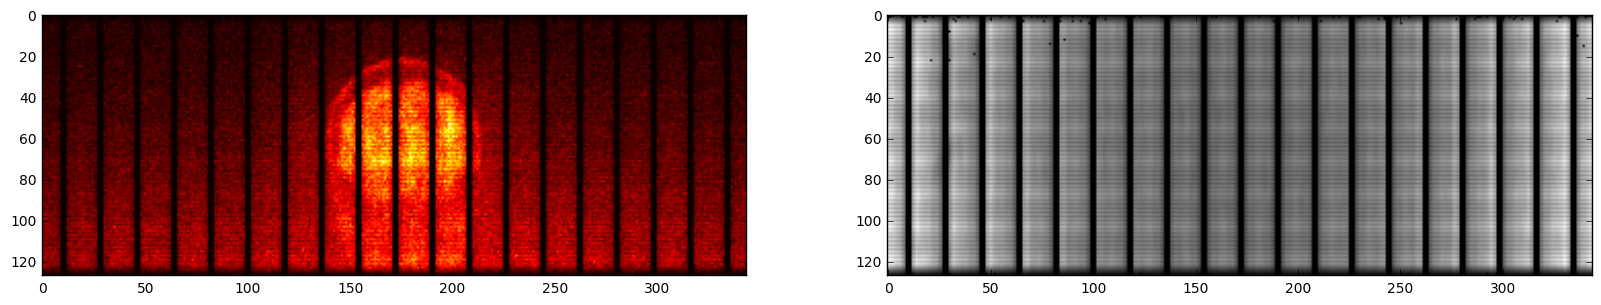

In [11]:
figure(figsize=[20,5])
subplot(1,2,1); imshow(flipud(prompts_data[0,5,:,:].transpose()), 'hot')
subplot(1,2,2); imshow(flipud(pet.sensitivity.data[0,5,:,:].transpose()), 'gray')

In [13]:
# Load attenuation
pet.import_attenuation(filename='../../data/PET_data/scans/2014_09_05_brain_nf_014_base/mumap_JSRecon/JSRecon-00-umap.v.hdr', 
                       filename_hardware='../../data/PET_data/scans/2014_09_05_brain_nf_014_base/mumap_JSRecon/JSRecon-00-umap-hardware.v.hdr')

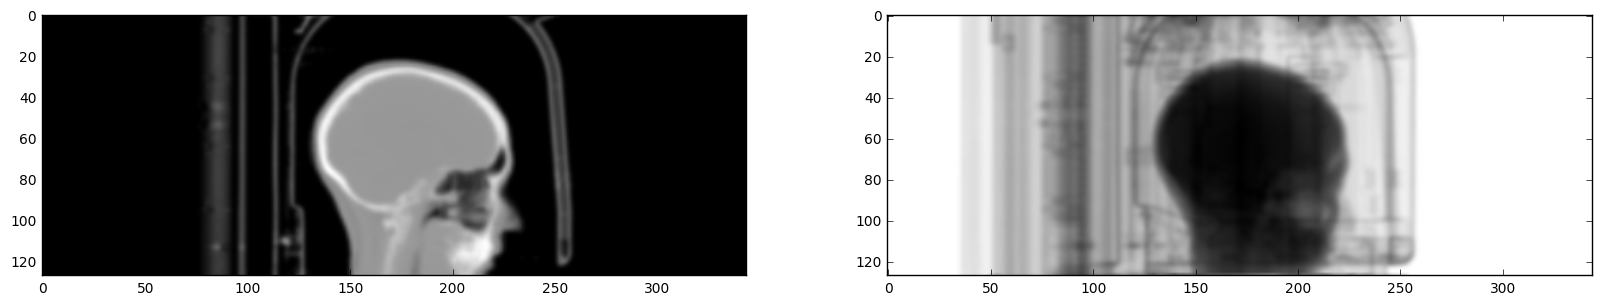

In [14]:
attenuation_projection = pet.project_attenuation(pet.attenuation)
figure(figsize=[20,5])
subplot(1,2,1); imshow(pet.attenuation.data[:,170,:].transpose(),'gray')
subplot(1,2,2); imshow(fliplr(flipud(attenuation_projection.data[252/180*90,5,:,:].transpose())),'gray')

In [15]:
pet.attenuation.save_to_file('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/occiput/attenuation.nii')

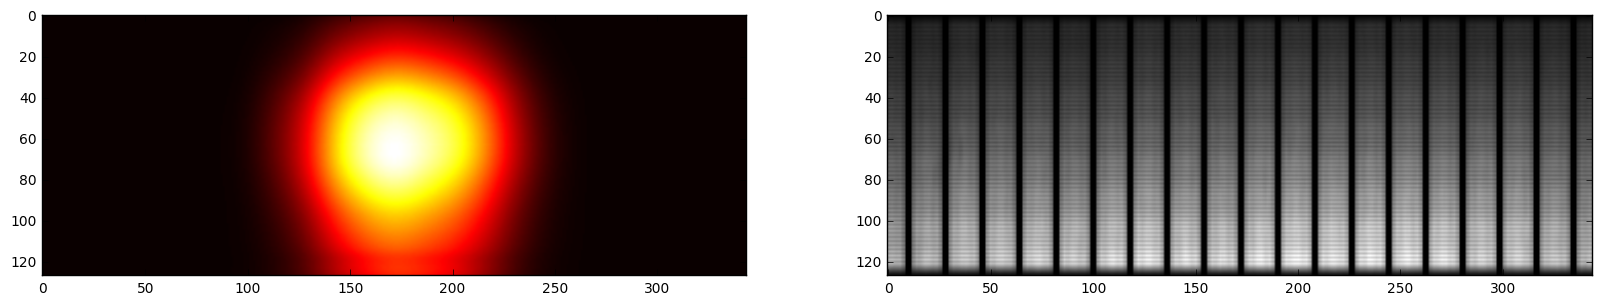

In [16]:
# Import smoothed randoms: 
pet.import_randoms('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/output/smoothed_rand_00.h33')

# Import scatter 
pet.import_scatter('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/scatter/brain_scatter3D.s.hdr')

figure(figsize=[20,5])
subplot(1,2,1); imshow(flipud(pet.scatter.data[0,5,:,:].transpose()),'hot')
subplot(1,2,2); imshow(flipud(pet.randoms.data[0,5,:,:].transpose()),'gray')

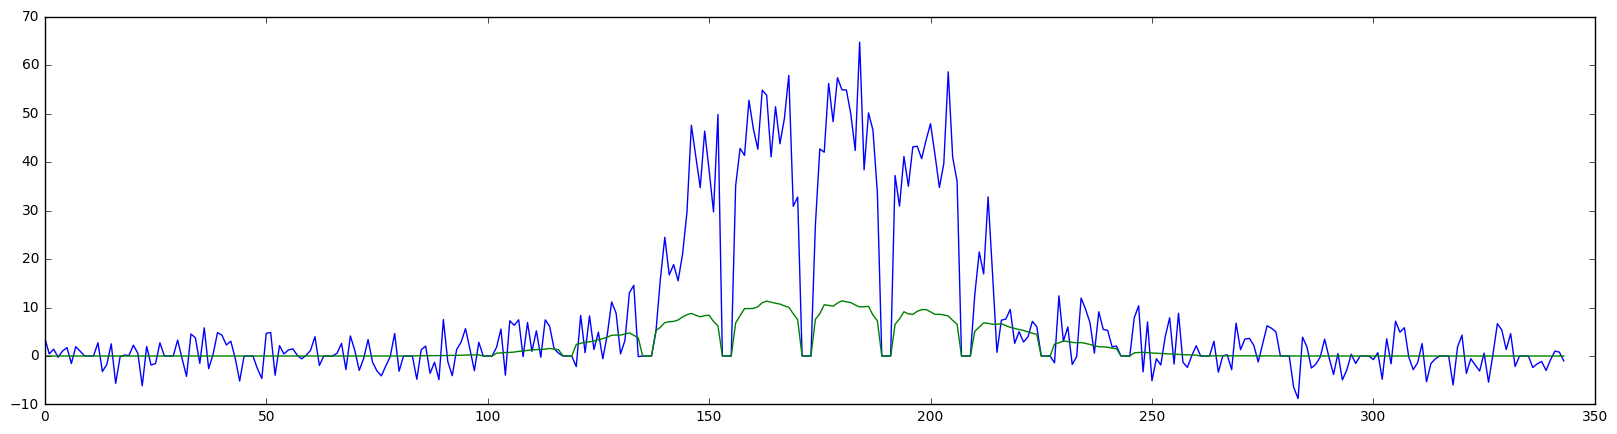

In [17]:
figure(figsize=[20,5])
plot(pet.prompts.to_nd_array()[0,5,:,60] - pet.randoms.data[0,5,:,60]); hold(1)
plot(pet.sensitivity.data[0,5,:,60] * pet.scatter.data[0,5,:,60],'g')

## OSEM Reconstruction 

In [69]:
#subsets_matrix = zeros([11,252],dtype=float32,order="C")
#subsets_matrix[5,:]=1

iterations = 20
activity_osem = pet.estimate_activity(iterations=iterations, subset_size=252*11/16)
activity_osem.save_to_file('%s/brain_osem_occiput_v044_iter%d.nii'%(results_data_path,iterations))

0.0 / 100
5.0 / 100
10.0 / 100
15.0 / 100
20.0 / 100
25.0 / 100
30.0 / 100
35.0 / 100
40.0 / 100
45.0 / 100
50.0 / 100
55.0 / 100
60.0 / 100
65.0 / 100
70.0 / 100
75.0 / 100
80.0 / 100
85.0 / 100
90.0 / 100
95.0 / 100
100.0 / 100
100.0 / 100


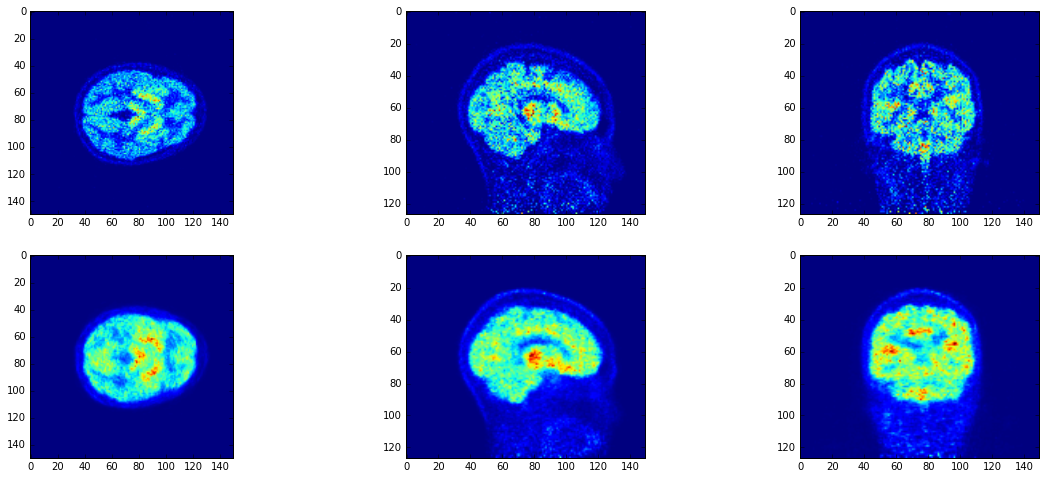

In [19]:
from occiput.DataSources.FileSources import import_interfile_volume, import_nifti
activity_scanner = import_interfile_volume('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/reconstructions/brain_uncomp_000_000.v.hdr')

figure(figsize=[20,8])
subplot(2,3,1); imshow(activity_scanner.data[100:250,100:250,64].transpose())
subplot(2,3,2); imshow(activity_scanner.data[100:250,172,:].transpose())
subplot(2,3,3); imshow(activity_scanner.data[172,100:250,:].transpose())

subplot(2,3,4); imshow(activity_osem.data[100:250,100:250,64].transpose())
subplot(2,3,5); imshow(activity_osem.data[100:250,172,:].transpose())
subplot(2,3,6); imshow(activity_osem.data[172,100:250,:].transpose())

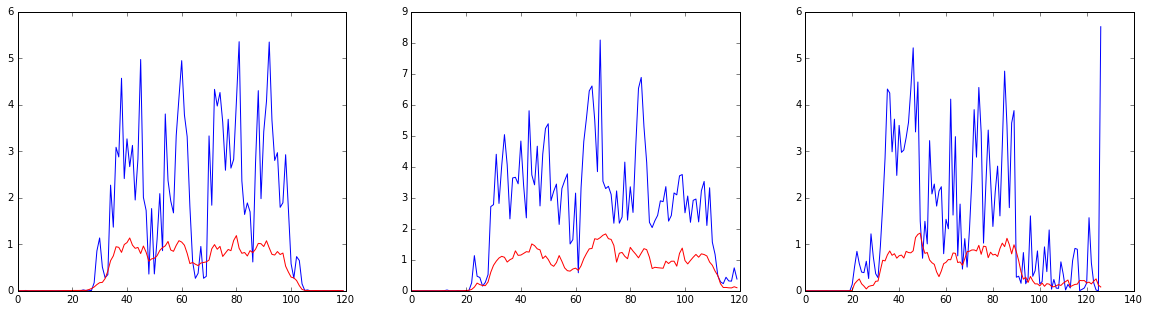

In [17]:
figure(figsize=[20,5])
subplot(1,3,1); plot(activity_scanner.data[172,110:230,64],'b'); hold(1); plot(activity_osem.data[172,110:230,64],'r')
subplot(1,3,2); plot(activity_scanner.data[110:230,172,64],'b'); hold(1); plot(activity_osem.data[110:230,172,64],'r')
subplot(1,3,3); plot(activity_scanner.data[172,172,:],'b'); hold(1); plot(activity_osem.data[172,172,:],'r')

## Reconstruction using anatomical information based on FreeSurfer

In [18]:
mri          = occiput.DataSources.FileSources.import_nifti('../../Stefano/freesurfer/mri_res.nii')
mask         = occiput.DataSources.FileSources.import_mask('../../Stefano/freesurfer/surf_aparc_res.nii')
lookup_table = occiput.DataSources.FileSources.load_freesurfer_lut_file('../../Stefano/freesurfer/freesurfer_aseg.lut')
mask.set_lookup_table(lookup_table)

In [19]:
def colored_labels(array): 
    [r,g,b,a] = lookup_table.convert_ndarray_to_rgba(array)
    s = zeros((r.shape[0],r.shape[1],4))
    s[:,:,0]=r; s[:,:,1]=g; s[:,:,2]=b; s[:,:,3]=255.0
    image = Image.fromarray(np.uint8(s))
    return image

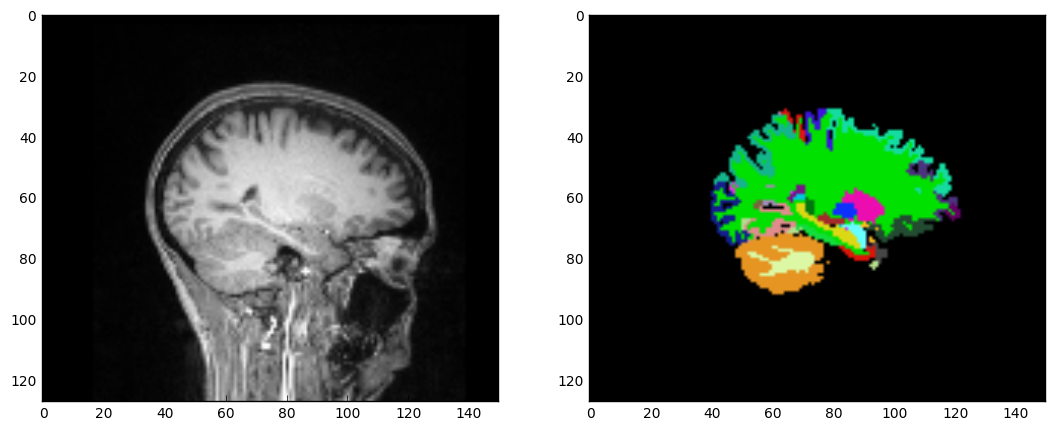

In [21]:
figure(figsize=[20,8])
subplot(1,3,1); imshow(activity_osem.data[100:250,165,:].transpose())
subplot(1,3,2); imshow(mri.data[100:250,165,:].transpose(),cmap='gray')
subplot(1,3,3); imshow(colored_labels(mask.data[100:250,165,:].transpose())) 

In [30]:
import scipy 
from numpy import * 
import occiput
from occiput.DataSources.FileSources import import_nifti
from occiput.Reconstruction.PET.PET import DEFAULT_RECON_ITERATIONS, DEFAULT_SUBSET_SIZE, EPS, ProgressBar
from matplotlib.pyplot import *
import sys
import copy 


class MixtureModel():
    def __init__(self, pet, sigma_init=0.1, do_update_sigma=False, alpha=1.20, beta=0.40, sigma_samples=10, verbose=False): 
        self.pet = pet 
        self.sigma_init = sigma_init
        self.sigma = copy.copy(sigma_init)
        self.do_update_sigma = do_update_sigma
        self.alpha = alpha
        self.beta = beta
        self.sigma_samples = 10 
        self.enable_plot(False)
        self.verbose = verbose

    def set_mask(self, mask): 
        self.mask = mask
        self.segmentation = int32(self.mask.data)  
        self.labels       = unique(self.segmentation) 
        self.N_labels = len(self.labels)

    def import_mask(self, filename): 
        mask = import_nifti(filename)
        self.set_mask(mask)

    def enable_plot(self, flag=True): 
        self._do_plot = flag

    def compute_mixture_expectations(self, volume): 
        mu = zeros([self.N_labels,])
        for label_index in range(self.N_labels):
            label = self.labels[label_index]
            indexes = (self.segmentation==label)
            if indexes is not []: 
                mu[label_index] = volume[indexes].mean() 
        if self.verbose: 
            print "MU min: %f    MU max: %f    MU mean: %f "%(mu.min(), mu.max(), mu.mean())
        sys.stdout.flush()
        return mu 

    def compute_mean_activity(self, volume): 
        mu = self.compute_mixture_expectations(volume)
        mean_activity = zeros(volume.shape)
        for label_index in range(self.N_labels):
            label = self.labels[label_index]
            mean_activity[self.segmentation==label] = mu[label_index]
        return mean_activity, mu

    def compute_difference(self, volume): 
        mu = zeros([self.N_labels,])
        difference = zeros(volume.shape,dtype=float32,order="F")
        for label_index in range( self.N_labels ):
            label = self.labels[label_index]
            indexes = (self.segmentation==label)
            if indexes is not []: 
                mu[label_index] = volume[indexes].mean() 
                diff = ( volume[indexes] - mu[label_index] )
                difference[indexes] = difference[indexes] + diff
        if self.verbose: 
            print "MU min: %f    MU max: %f    MU mean: %f "%(mu.min(), mu.max(), mu.mean())
        sys.stdout.flush()
        return mu, difference

    def estimate_sigma(self, volume): 
        max_value = volume.max()
        x = linspace(0.0, max_value, 10000)
        gamma = scipy.stats.gamma(a=alpha, scale=1.0/beta)
        y = gamma.pdf(x)

        max_index = where(y == y.max())[0][0]
        sigma_indexes = max_index * int32(range(1,self.sigma_samples+1))

        sigmas           = x[sigma_indexes]
        gamma_values     = y[sigma_indexes]
        log_gamma_values = log(gamma_values)

        if self._do_plot: 
            plot(x,y)
            hold(1)
            plot(sigmas, gamma_values,'o') 
    
        log_posterior = zeros( (volume.shape[0], volume.shape[1], volume.shape[2], self.sigma_samples), dtype='float32', order='F' )

        [mu, diff] = self.compute_difference(volume)
        for i in range(self.sigma_samples): 
            sigma = sigmas[i]
            log_gamma = log_gamma_values[i]
            log_gaussian = -log(sigma)-diff**2/(2.0*sigma*sigma)
            log_posterior[:,:,:,i] = log_gamma+log_gaussian  

        m = log_posterior.argmax(axis=3)

        sigma_estimate = zeros( volume.shape, dtype='float32', order='F' )

        n_voxels_sigma = zeros([self.sigma_samples,])
        for i in range(self.sigma_samples): 
            indexes = (m==i)
            sigma_estimate[indexes] = sigmas[i]
            n_voxels_sigma[i] = indexes.sum()
        if self.verbose: 
            print "Sigma: ",sigma_estimate, n_voxels_sigma
        sys.stdout.flush()
        sys.stdout.flush()
        return mu, sigmas, sigma_estimate

    def compute_gradient_prior(self, volume): 
        if not self.do_update_sigma: 
            [mu,gradient_prior] = self.compute_difference(volume)
        else: 
            [mu, sigmas, sigma] = self.estimate_sigma(volume) 
            self.sigma = sigma 
            [mu,gradient_prior] = self.compute_difference(volume)
        self.mu = mu
        return mu, self.sigma, gradient_prior

    def estimate_activity(self, activity=None, attenuation=None, iterations=DEFAULT_RECON_ITERATIONS, sparsity=None, 
                               subset_size=DEFAULT_SUBSET_SIZE, subset_mode='random', epsilon=None, subsets_matrix=None, 
                               azimuthal_range=None, show_progressbar=True): 
        # Optionally use the specified value of epsilon (small number added to the denominator is divisions)
        if epsilon is None: 
            epsilon = EPS 

        if pet.prompts is None: 
            print "pet.prompts is None, please set prompts. " 
            return 
            # FIXME : throw an error 

        duration_ms = pet.prompts.get_duration() 
        
        if show_progressbar: 
            progress_bar = ProgressBar() 
            progress_bar.set_percentage(0.1) 
        
        #print "Projection of the attenuation. "
        if attenuation is None:
            attenuation = pet.attenuation 
        if attenuation is not None: 
            pet.attenuation_projection = pet.project_attenuation(attenuation) #FIXME: now it's only here that this is defined
        else: 
            pet.attenuation_projection = 1.0
        
        if activity is None: 
            activity = pet._make_Image3D_activity(ones(pet.activity_shape,dtype=float32,order="F")) 
        # FIXME: use transformation - also notice that roi_activity is always set to None here
    
        MU = zeros([iterations,self.N_labels])
        
        for iteration in range(iterations): 
            # Estimate mixture parameters and compute the gradient of the log prior: 
            [mu, sigma, gradient_prior] = self.compute_gradient_prior(activity.data)
            MU[iteration,:] = mu
            
            # Estimate gradient of the log likelihood 
            [gradient1, gradient2, subsets_matrix] = pet.get_gradient_activity(activity,pet.attenuation_projection,
                                                                         roi_activity=None, 
                                                                         sparsity=sparsity,
                                                                         duration_ms=duration_ms, subset_size=subset_size,
                                                                         subset_mode=subset_mode, subsets_matrix=subsets_matrix,
                                                                         azimuthal_range=azimuthal_range,
                                                                         separate_additive_terms=True, epsilon=epsilon) 
            activity = activity * gradient2 / (gradient1+ gradient_prior / (sigma**2) + epsilon) 
            if show_progressbar: 
                progress_bar.set_percentage((iteration+1)*100.0/iterations) 

        if show_progressbar: 
            progress_bar.set_percentage(100.0) 
        return activity, MU 

In [ ]:
# Fine reconstruction 

iterations      = 40
sigma           = 0.35
do_update_sigma = False
alpha           = 1.20
beta            = 0.33
sigma_samples   = 10
verbose         = False 

mixture = MixtureModel(pet, sigma, do_update_sigma, alpha, beta, sigma_samples, verbose)
mixture.set_mask(mask)
[activity_mixture, MU] = mixture.estimate_activity(activity=activity_osem, subset_size=252*11/16, iterations=iterations)
activity_mixture.save_to_file('../../data/PET_data/scans/2014_09_05_brain_nf_014_base/occiput/activity_mixture_occiput_v100_iter40_sigma0dot35.nii'%results_data_path)

0.0 / 100
MU min: 0.005585    MU max: 1.516052    MU mean: 0.931189 
2.0 / 100
MU min: 0.005414    MU max: 1.537323    MU mean: 0.932645 
5.0 / 100
MU min: 0.005301    MU max: 1.568580    MU mean: 0.938772 
7.0 / 100
MU min: 0.005213    MU max: 1.603305    MU mean: 0.946219 
10.0 / 100
MU min: 0.005140    MU max: 1.639062    MU mean: 0.953832 
12.0 / 100
MU min: 0.005077    MU max: 1.674918    MU mean: 0.961231 
15.0 / 100
MU min: 0.005022    MU max: 1.710510    MU mean: 0.968306 
17.0 / 100
MU min: 0.004973    MU max: 1.745702    MU mean: 0.975042 
20.0 / 100
MU min: 0.004928    MU max: 1.780442    MU mean: 0.981457 
22.0 / 100
MU min: 0.004886    MU max: 1.814713    MU mean: 0.987573 
25.0 / 100
MU min: 0.004848    MU max: 1.848515    MU mean: 0.993415 
27.0 / 100
MU min: 0.004813    MU max: 1.881848    MU mean: 0.999007 
30.0 / 100
MU min: 0.004780    MU max: 1.914717    MU mean: 1.004366 
32.0 / 100
MU min: 0.004749    MU max: 1.947128    MU mean: 1.009512 
35.0 / 100
MU min: 0.004

In [ ]:
[activity_mean_mixture, mu_mixture] = mixture.compute_mean_activity(activity_mixture.data) 
[activity_mean_osem,    mu_osem   ] = mixture.compute_mean_activity(activity_osem.data) 

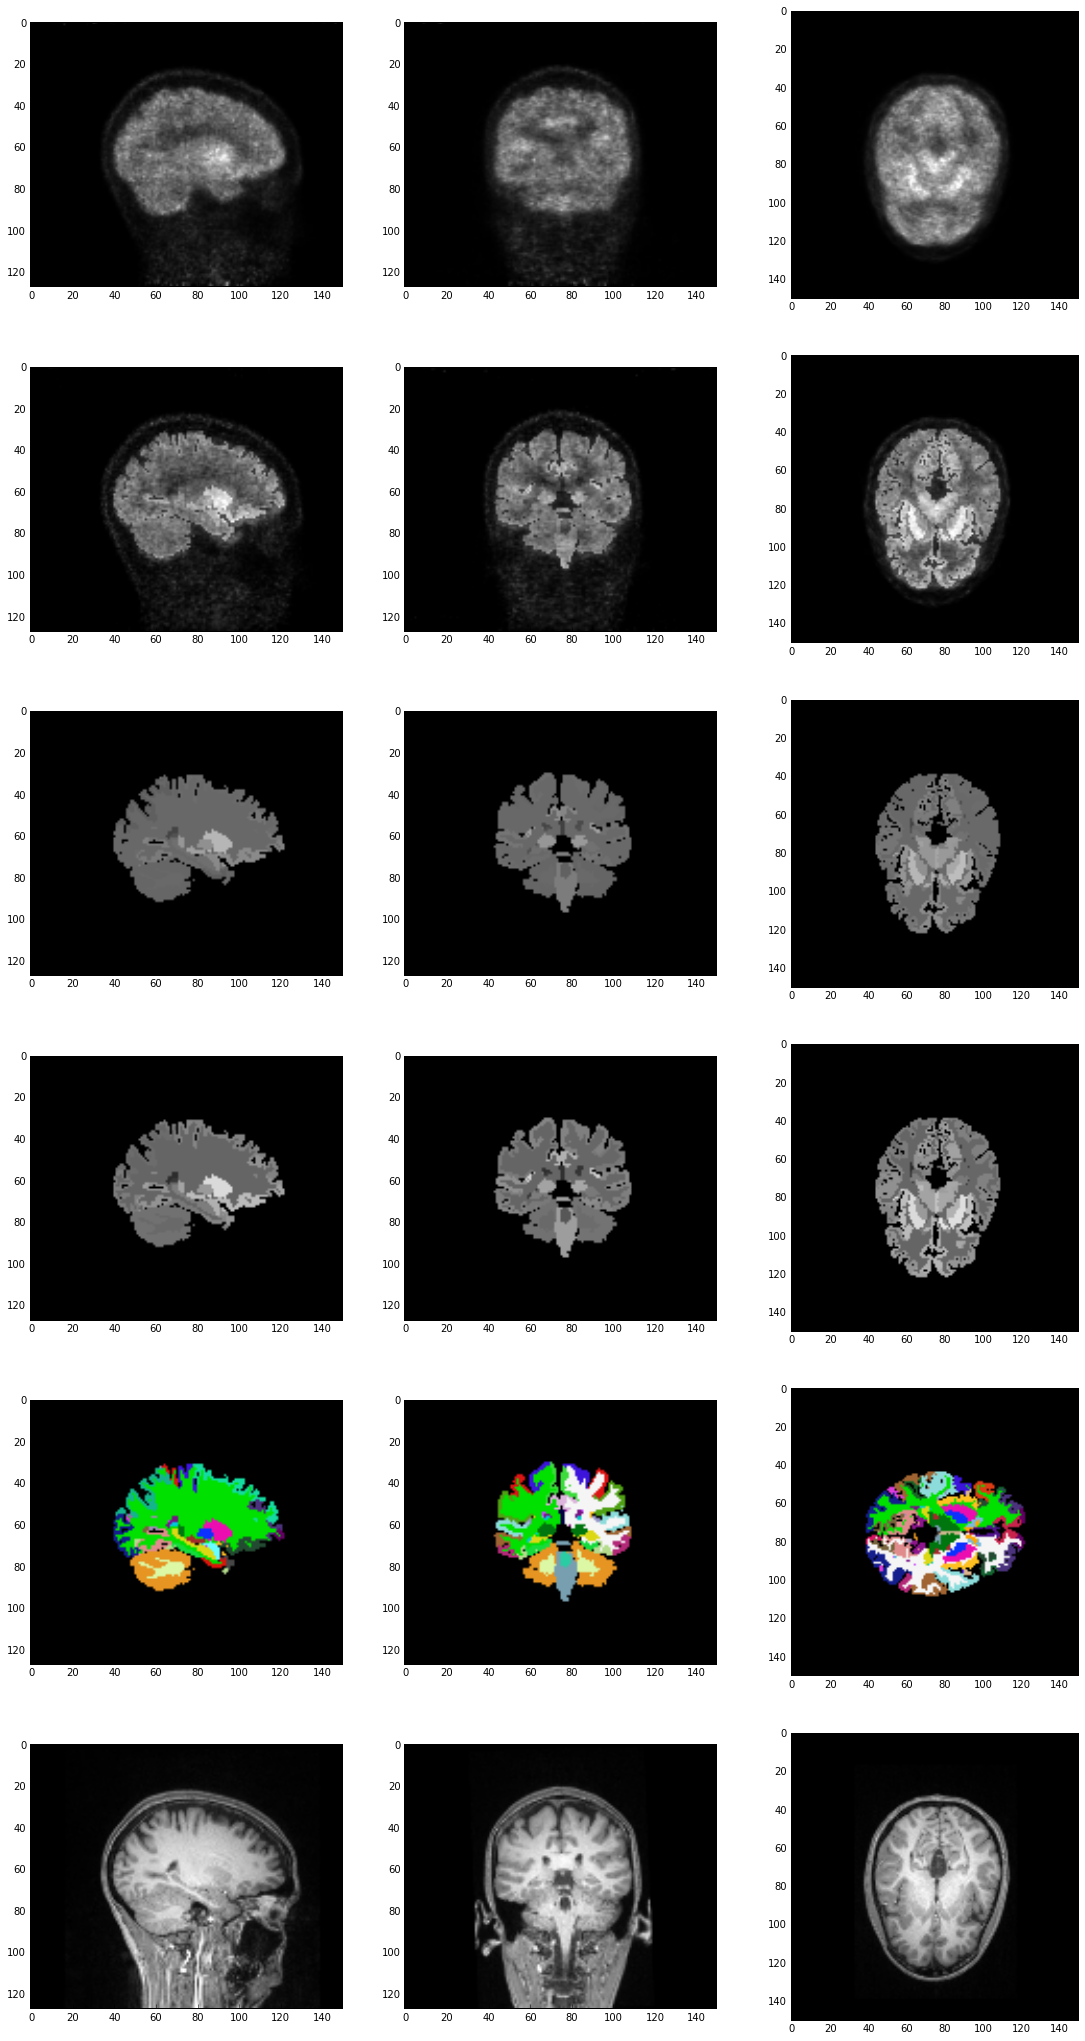

In [29]:
activity_max = 2.0
figure(figsize=[19,36])
color = 'gray'
X = 172
Y = 165
Z = 64

subplot(631); imshow(activity_osem.data[100:250,Y,:].transpose(),cmap=color,vmax=activity_max)
subplot(632); imshow(activity_osem.data[X,100:250,:].transpose(),cmap=color,vmax=activity_max)
subplot(633); imshow(activity_osem.data[100:250,100:250,Z],cmap=color,vmax=activity_max)

subplot(634); imshow(activity_mixture.data[100:250,Y,:].transpose(),cmap=color,vmax=activity_max)
subplot(635); imshow(activity_mixture.data[X,100:250,:].transpose(),cmap=color,vmax=activity_max)
subplot(636); imshow(activity_mixture.data[100:250,100:250,Z],cmap=color,vmax=activity_max)

subplot(637); imshow(activity_mean_osem[100:250,Y,:].transpose(),cmap=color,vmax=activity_max)
subplot(638); imshow(activity_mean_osem[X,100:250,:].transpose(),cmap=color,vmax=activity_max)
subplot(639); imshow(activity_mean_osem[100:250,100:250,Z],cmap=color,vmax=activity_max)

subplot(6,3,10); imshow(activity_mean_mixture[100:250,Y,:].transpose(),cmap=color,vmax=activity_max)
subplot(6,3,11); imshow(activity_mean_mixture[X,100:250,:].transpose(),cmap=color,vmax=activity_max)
subplot(6,3,12); imshow(activity_mean_mixture[100:250,100:250,Z],cmap=color,vmax=activity_max)

subplot(6,3,13); imshow(colored_labels(mask.data[100:250,Y,:].transpose()))
subplot(6,3,14); imshow(colored_labels(mask.data[X,100:250,:].transpose()))
subplot(6,3,15); imshow(colored_labels(mask.data[100:250,100:250,Z].transpose()))

subplot(6,3,16); imshow(mri.data[100:250,Y,:].transpose(),cmap='gray')
subplot(6,3,17); imshow(mri.data[X,100:250,:].transpose(),cmap='gray')
subplot(6,3,18); imshow(mri.data[100:250,100:250,Z],cmap='gray')